In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Dataset Link https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/data

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

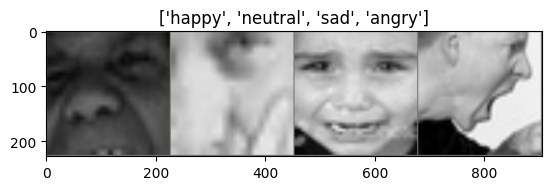

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from Tensor image
    # to numpy image, unnormalize
    # Reverse normalization
    # Note: The mean and std values are for the ImageNet dataset.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training # true =-> model was in training mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
fruits = ['apple', 'banana', 'cherry']
for index, fruit in enumerate(fruits, start=1):
    print(f"Index {index}: {fruit}")

Index 1: apple
Index 2: banana
Index 3: cherry


## Option 1: Fine-tuning the entire ResNet18 model:

#### all layers (including convolutional layers) are updated during training.

In [6]:
from torchvision.models import ResNet18_Weights
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6560 Acc: 0.3641
val Loss: 1.2125 Acc: 0.5483

Epoch 1/24
----------
train Loss: 1.4162 Acc: 0.4522
val Loss: 1.1301 Acc: 0.5753

Epoch 2/24
----------
train Loss: 1.3386 Acc: 0.4852
val Loss: 1.0824 Acc: 0.5968

Epoch 3/24
----------
train Loss: 1.2835 Acc: 0.5080
val Loss: 1.0655 Acc: 0.6185

Epoch 4/24
----------
train Loss: 1.2504 Acc: 0.5207
val Loss: 0.9975 Acc: 0.6316

Epoch 5/24
----------
train Loss: 1.2253 Acc: 0.5318
val Loss: 1.0561 Acc: 0.6134

Epoch 6/24
----------
train Loss: 1.1995 Acc: 0.5405
val Loss: 0.9963 Acc: 0.6340

Epoch 7/24
----------
train Loss: 1.1070 Acc: 0.5791
val Loss: 0.9387 Acc: 0.6585

Epoch 8/24
----------
train Loss: 1.0837 Acc: 0.5884
val Loss: 0.9320 Acc: 0.6581

Epoch 9/24
----------
train Loss: 1.0634 Acc: 0.5972
val Loss: 0.9277 Acc: 0.6642

Epoch 10/24
----------
train Loss: 1.0602 Acc: 0.5954
val Loss: 0.9091 Acc: 0.6727

Epoch 11/24
----------
train Loss: 1.0510 Acc: 0.5963
val Loss: 0.9075 Acc: 0.6703

Ep

In [ ]:
torch.save(model_ft.state_dict(), 'model_ft.pth')

NameError: name 'model_ft' is not defined

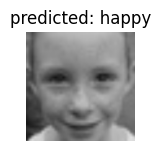

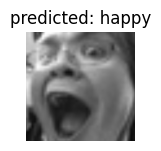

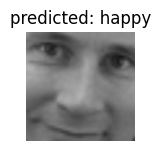

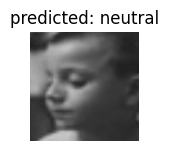

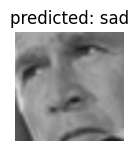

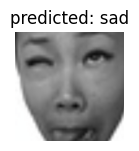

In [8]:
visualize_model(model_ft)

## Option 2: Training Only Classifier

#### freeze all layers except the final fully connected layer

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9669 Acc: 0.2622
val Loss: 1.7757 Acc: 0.3330

Epoch 1/24
----------
train Loss: 1.9817 Acc: 0.2681
val Loss: 1.7304 Acc: 0.3585

Epoch 2/24
----------
train Loss: 1.9763 Acc: 0.2729
val Loss: 1.6910 Acc: 0.3787

Epoch 3/24
----------
train Loss: 1.9801 Acc: 0.2730
val Loss: 2.1489 Acc: 0.3364

Epoch 4/24
----------
train Loss: 1.9795 Acc: 0.2715
val Loss: 2.3816 Acc: 0.3314

Epoch 5/24
----------
train Loss: 1.9664 Acc: 0.2784
val Loss: 1.7818 Acc: 0.3650

Epoch 6/24
----------
train Loss: 1.9798 Acc: 0.2716
val Loss: 1.8154 Acc: 0.3487

Epoch 7/24
----------
train Loss: 1.7205 Acc: 0.3152
val Loss: 1.5754 Acc: 0.3967

Epoch 8/24
----------
train Loss: 1.7010 Acc: 0.3221
val Loss: 1.5448 Acc: 0.4050

Epoch 9/24
----------
train Loss: 1.6899 Acc: 0.3263
val Loss: 1.5602 Acc: 0.4080

Epoch 10/24
----------
train Loss: 1.6866 Acc: 0.3240
val Loss: 1.5601 Acc: 0.4039

Epoch 11/24
----------
train Loss: 1.6885 Acc: 0.3281
val Loss: 1.5623 Acc: 0.4042

Ep

In [18]:
torch.save(model_conv.state_dict(), 'model_conv.pth')

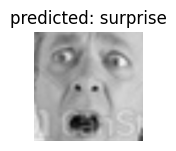

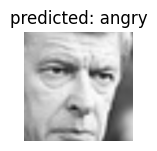

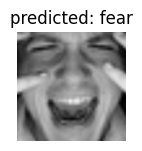

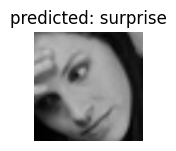

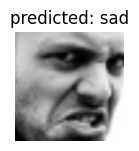

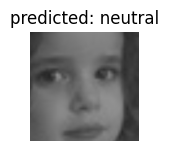

In [8]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Model inference

In [9]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [24]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a function to load and preprocess the image
def preprocess_image(image_path):
    # Open the image and convert it to RGB
    img = Image.open(image_path).convert('RGB')
    # Apply the transformations
    img_tensor = data_transform(img)
    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

img_path = r'D:\00_google_classroom\machinelearning.ai\02_transfer_learning\images\images\valid\neutral\60.jpg'

img_tensor = preprocess_image(img_path)

visualize_model_predictions(
    model_conv,
    img_tensor
)

plt.ioff()
plt.show()

AttributeError: 'Tensor' object has no attribute 'read'